In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_palette("Set2")
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing

In [2]:
df = fetch_california_housing(as_frame=True)['frame']

In [3]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [4]:
print("Number and names of features:", len(df.columns) - 1, set(df.columns) - {'MedHouseVal'})
print("Target feature: MedHouseVal")
print("Number of data points:", df.shape[0])

Number and names of features: 8 {'Population', 'MedInc', 'AveOccup', 'Longitude', 'Latitude', 'HouseAge', 'AveRooms', 'AveBedrms'}
Target feature: MedHouseVal
Number of data points: 20640


# EDA

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
MedHouseVal,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010


C:\Users\User\AppData\Local\Temp\ipykernel_2152\2937189140.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax = ax, bins=30)


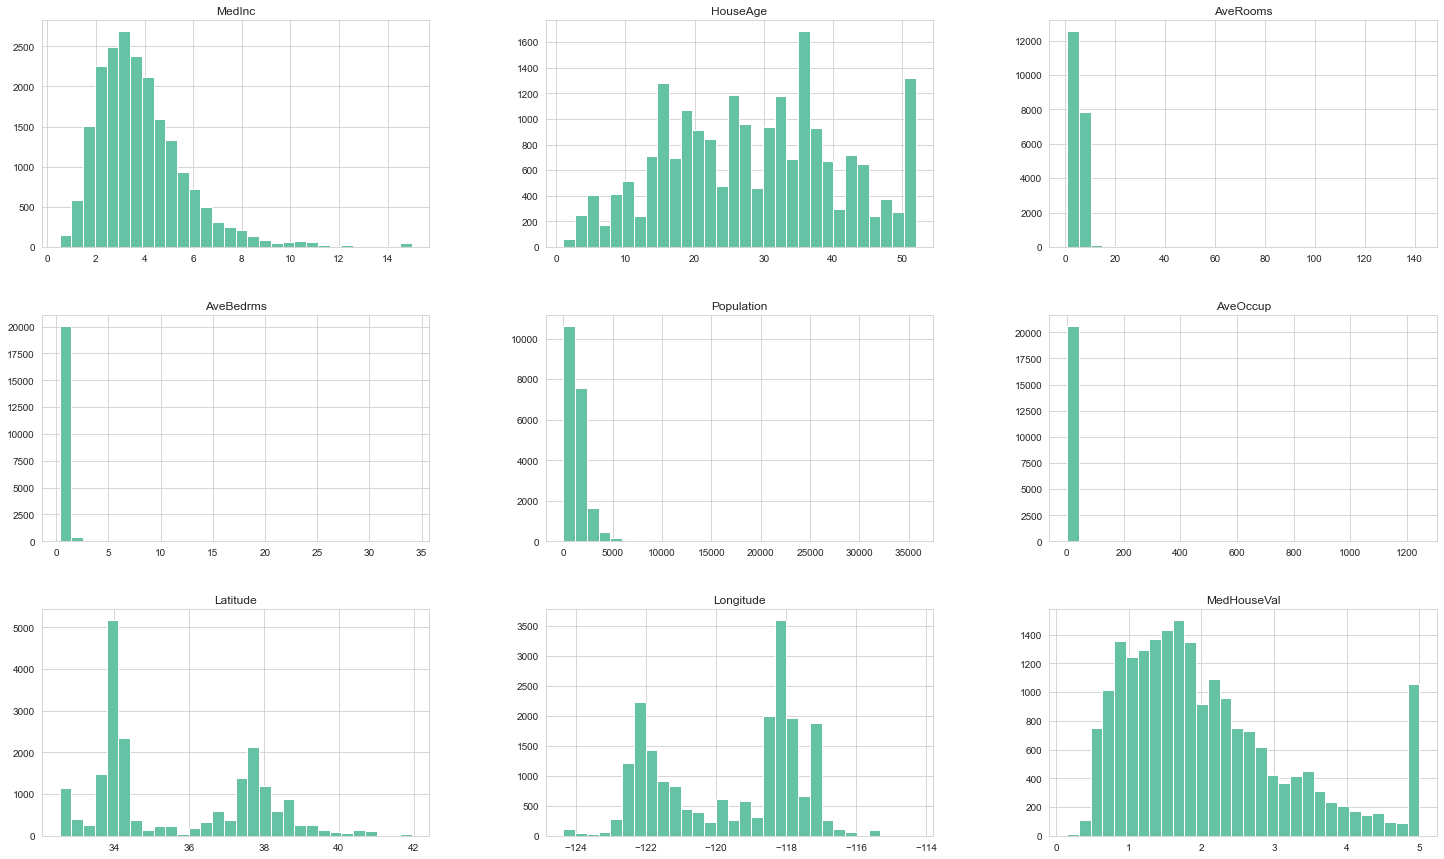

In [6]:
ax = plt.figure(figsize=(25, 15))
df.hist(ax = ax, bins=30)
plt.show()

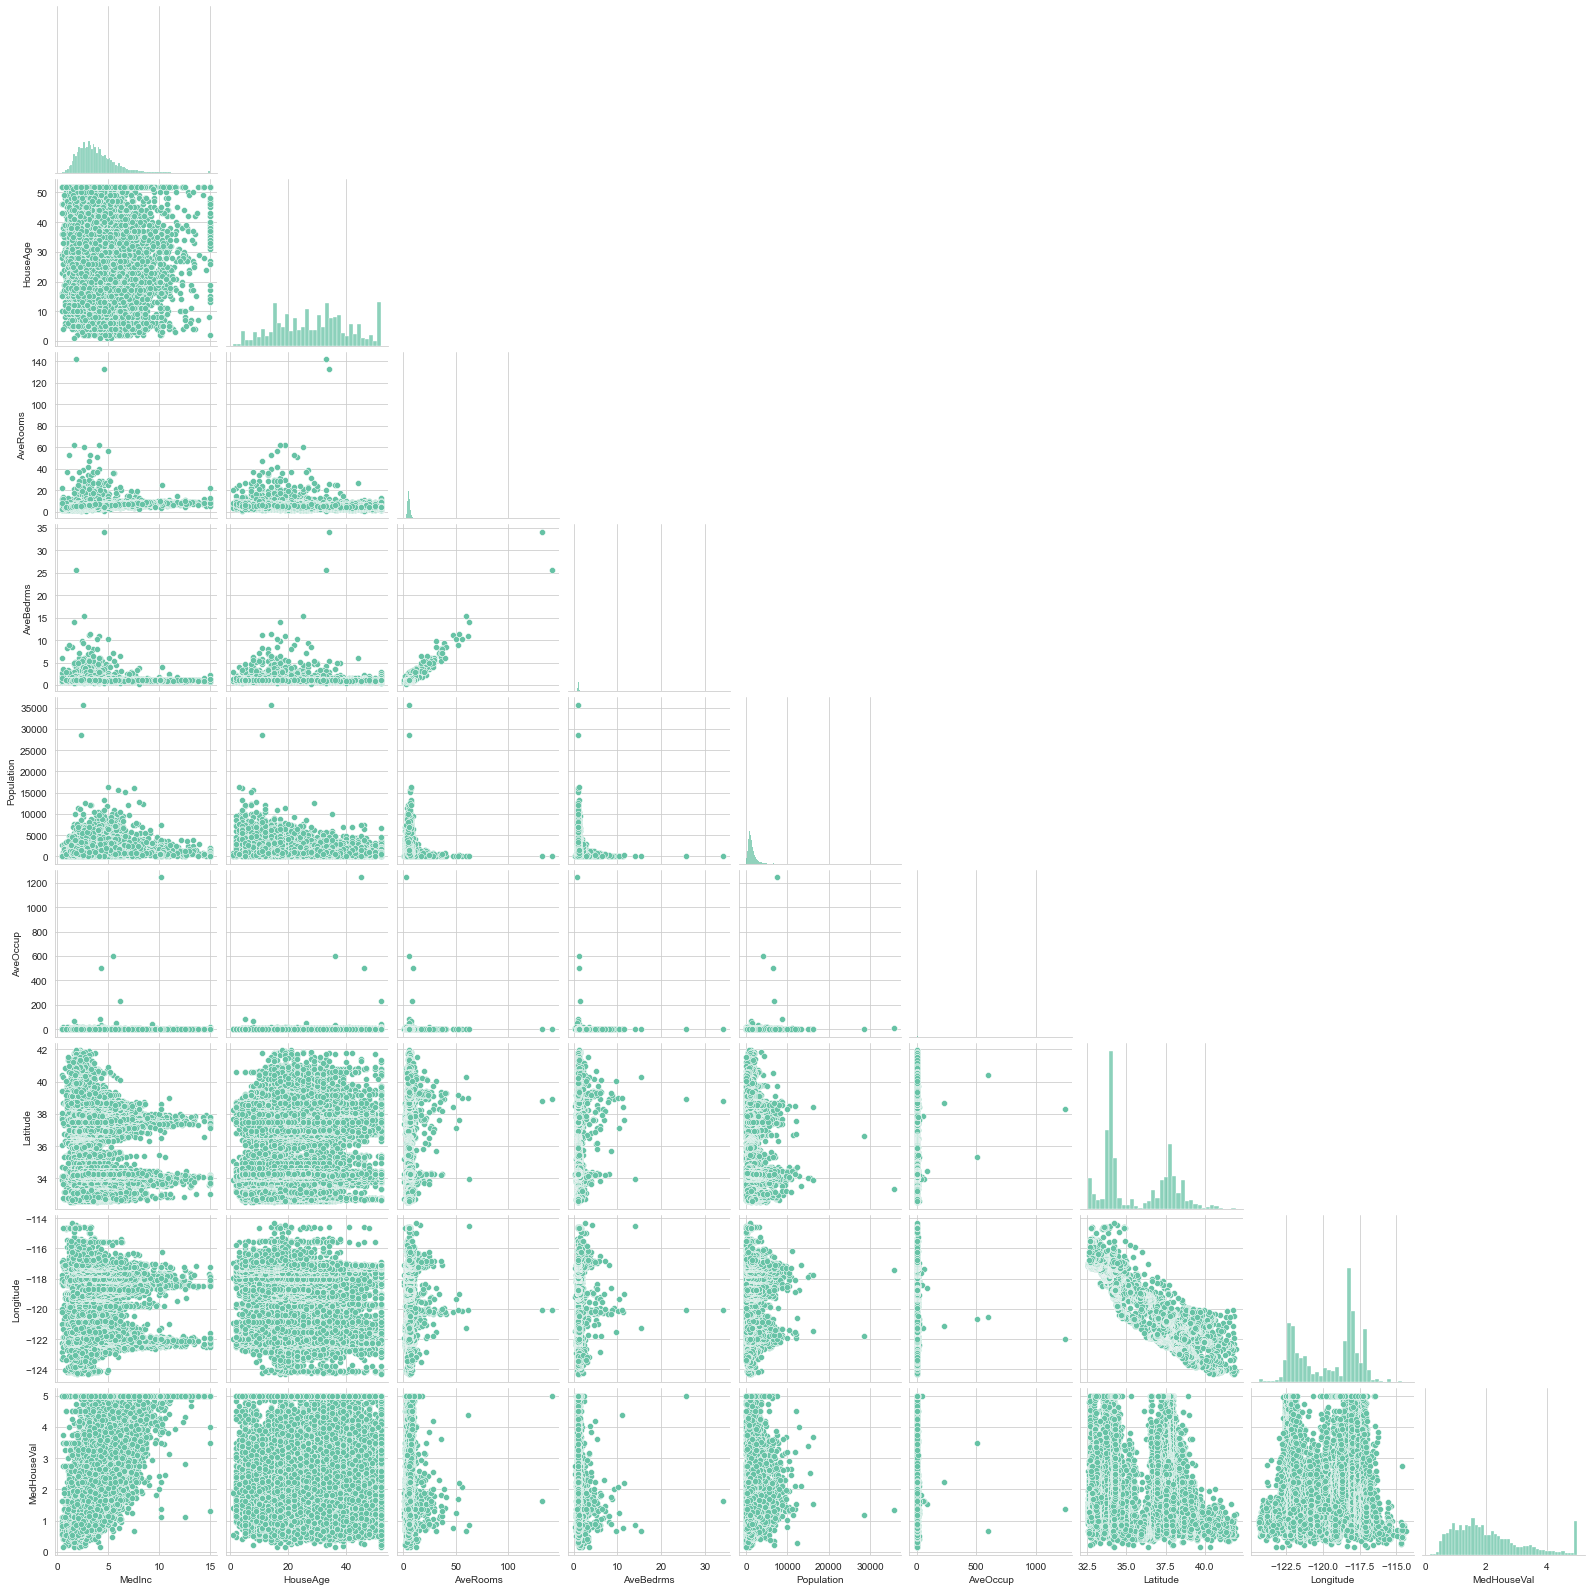

In [7]:
sns.pairplot(df, corner=True)

# Splitting the dataset

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer

train_df, test_df = train_test_split(df, train_size=0.8, random_state=321)
print(train_df.shape, test_df.shape)

(16512, 9) (4128, 9)


# Feature Engineering

## Log transforms

In [9]:
log_transformer = FunctionTransformer(lambda x: np.log1p(x))
log_transform_columns = list(set(df.columns) - {'Latitude', 'Longitude', 'HouseAge'})
train_df[log_transform_columns] = pd.DataFrame(log_transformer.fit_transform(train_df[log_transform_columns]), columns=log_transform_columns, index=train_df.index)
test_df[log_transform_columns] = pd.DataFrame(log_transformer.transform(test_df[log_transform_columns]), columns=log_transform_columns, index=test_df.index)

## Scaling

In [10]:
scaler = MinMaxScaler()
train_df = pd.DataFrame(scaler.fit_transform(train_df), columns=train_df.columns, index=train_df.index)
test_df = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns, index=test_df.index)

C:\Users\User\AppData\Local\Temp\ipykernel_2152\1840883562.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  train_df.hist(ax = ax, bins=30)


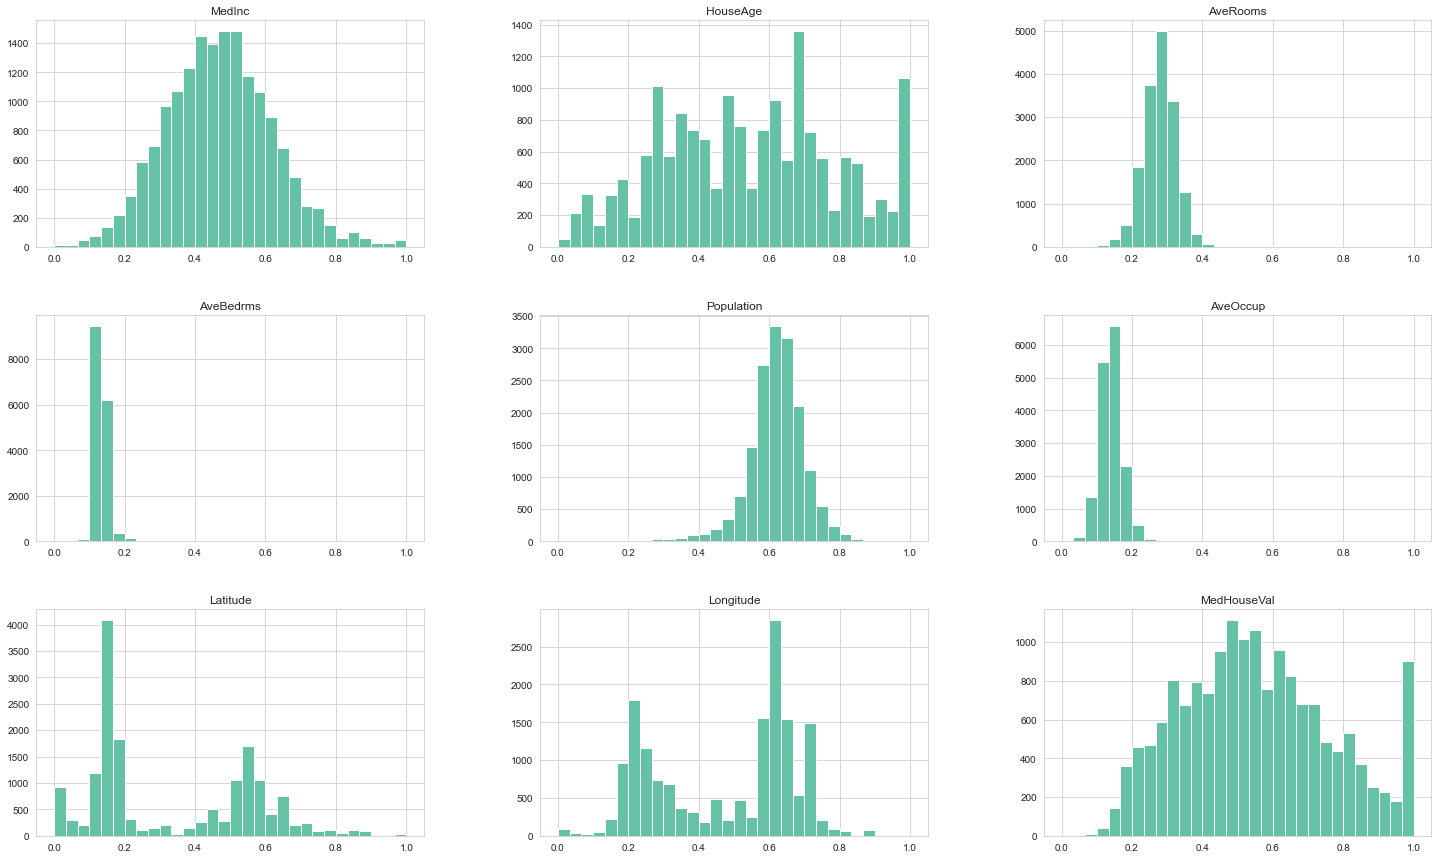

In [11]:
ax = plt.figure(figsize=(25, 15))
train_df.hist(ax = ax, bins=30)
plt.show()

## Clustering

Coordinates are natural candidates for clustering, so we will attempt to use them together with MedInc to derive a new feature that indicates the cluster in which the entry belongs to.

In [12]:
from sklearn.cluster import KMeans

clustering_columns = ['Latitude', 'Longitude', 'MedInc']

kmeans = KMeans(n_clusters=7, random_state=23)
clusters_train = kmeans.fit_predict(train_df[clustering_columns])
clusters_test = kmeans.predict(test_df[clustering_columns])
train_df['Cluster'] = np.round((clusters_train - clusters_train.min()) / (clusters_train.max() - clusters_train.min()), 4)
test_df['Cluster'] = np.round((clusters_test - clusters_test.min()) / (clusters_test.max() - clusters_test.min()), 4)

We can see that the cluster attribute effectively distinguishes the data with respect to the target characteristic.

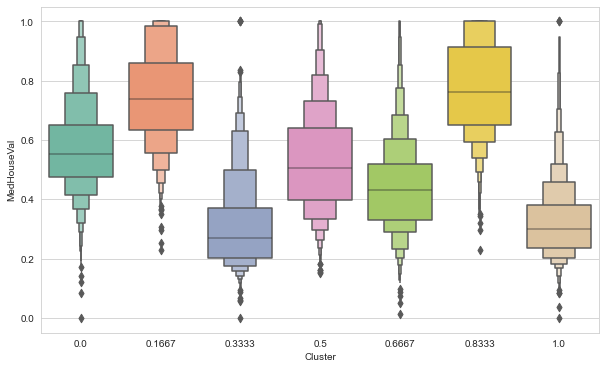

In [13]:
plt.figure(figsize=(10, 6))
sns.boxenplot(data=train_df, x='Cluster', y='MedHouseVal')
plt.show()

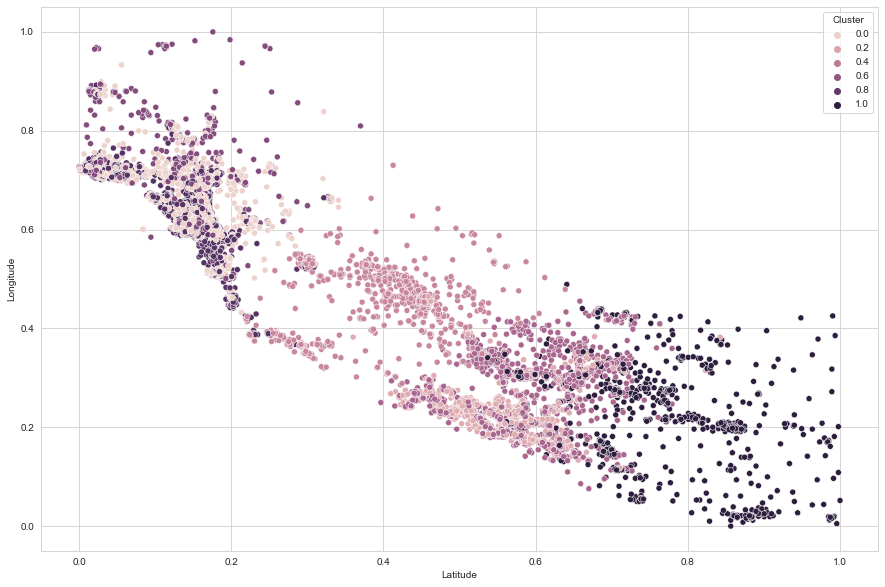

In [14]:
plt.figure(figsize=(15, 10))
sns.scatterplot(data=train_df, x='Latitude', y='Longitude', hue='Cluster')
plt.show()

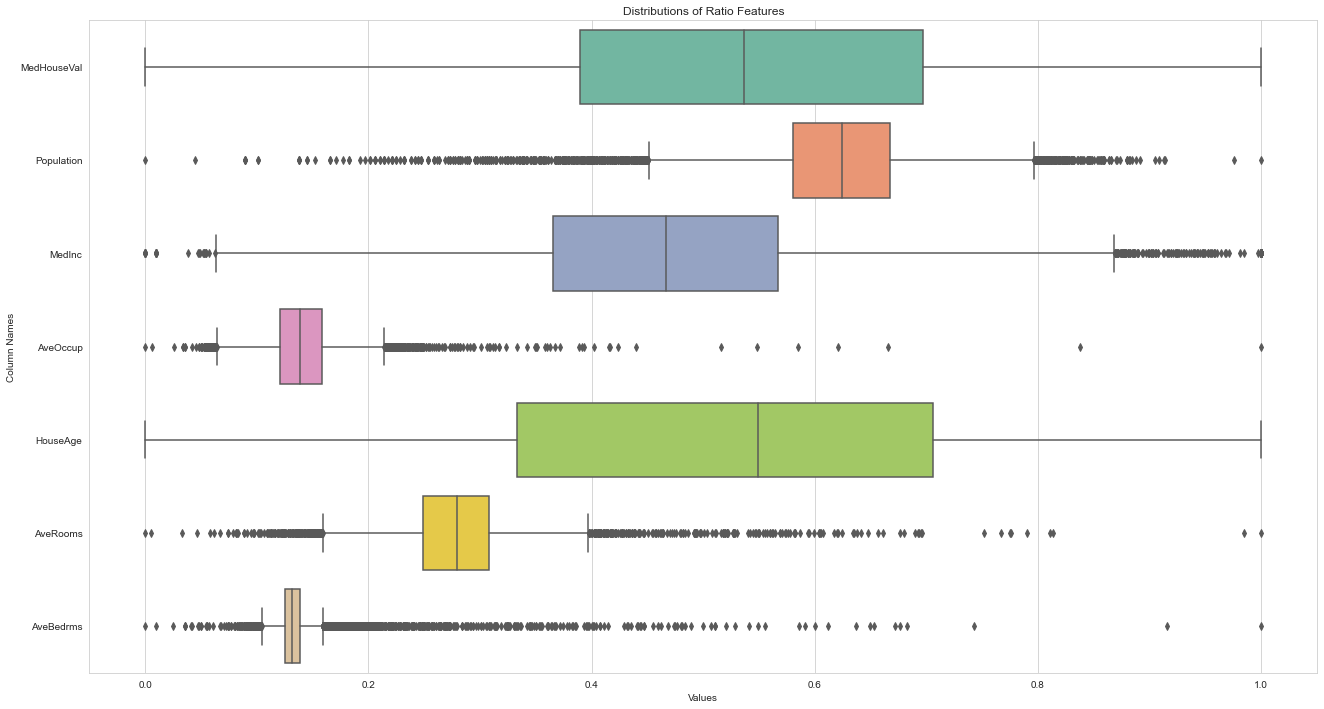

In [15]:
plt.figure(figsize=(22, 12))
ratio_features = list(set(df.columns) - {'Latitude', 'Longitude', 'Cluster'})
ax = sns.boxplot(data=train_df[ratio_features], orient='h')

ax.set_title('Distributions of Ratio Features')
ax.set_ylabel('Column Names')
ax.set_xlabel('Values')

plt.show()

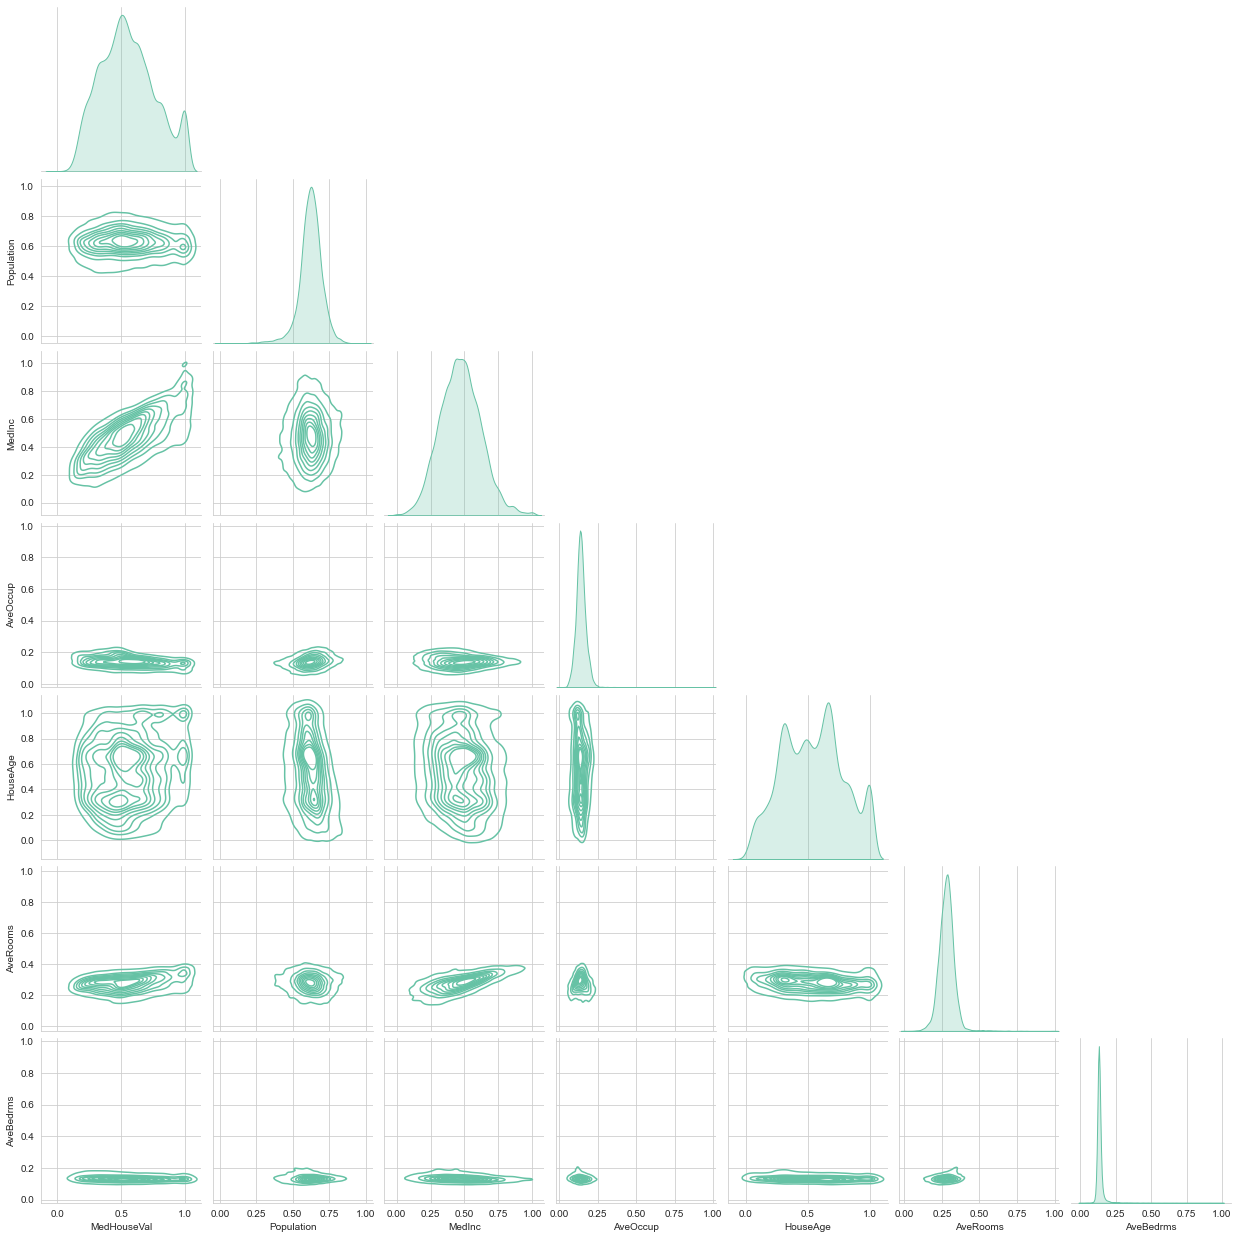

In [16]:
sns.pairplot(train_df[ratio_features], corner=True, kind="kde")

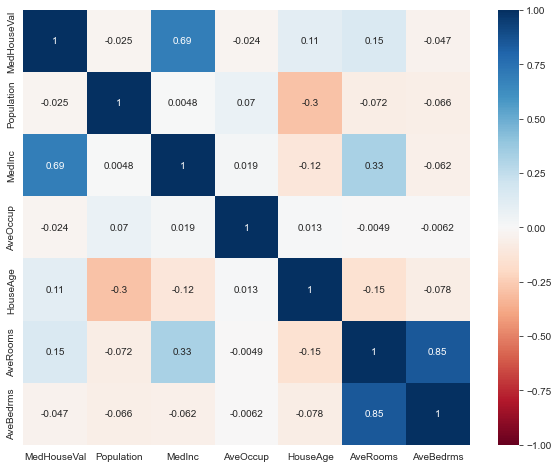

In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    df[ratio_features].corr(method='pearson'),
    cmap='RdBu',
    annot=True,
    vmin=-1,
    vmax=1
)
plt.show()

# Models

In [18]:
train_y = train_df['MedHouseVal'].copy()
train_X = train_df.drop('MedHouseVal', inplace=False, axis=1).copy()

test_y = test_df['MedHouseVal'].copy()
test_X = test_df.drop('MedHouseVal', inplace=False, axis=1).copy()

In [19]:
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(16512, 9) (16512,)
(4128, 9) (4128,)


In [20]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

In [21]:
train_y.describe()

count    16512.000000
mean         0.553082
std          0.215260
min          0.000000
25%          0.389918
50%          0.536925
75%          0.697306
max          1.000000
Name: MedHouseVal, dtype: float64

In [22]:
def print_results(model, test_y, y_hat):
    print("Coefficients: ", model.coef_)
    print("   Intercept: ", model.intercept_)
    if hasattr(model, 'alpha_'):
        print("       Alpha: ", model.alpha_)
    print("         MSE: ", mean_squared_error(test_y, y_hat))
    print("          R2: ", r2_score(test_y, y_hat))

In [23]:
def plot_residuals(test_y, y_hat):
    residuals = test_y - y_hat.reshape(-1)
    fig, axs = plt.subplots(1, 2, figsize=(25, 5))
    sns.histplot(x=residuals, ax=axs[0])
    axs[0].axvline(x=0, color='r')
    axs[0].axvline(x=np.mean(np.array(residuals)), color='y')
    sns.boxplot(x=residuals, ax=axs[1])
    fig.show()

## Linear Regression

In [24]:
lr = LinearRegression()
lr.fit(train_X, train_y)
y_hat_lr = lr.predict(test_X)
print_results(lr, test_y, y_hat_lr)

Coefficients:  [ 1.04717076  0.08388762 -0.72424404  1.20870052  0.05187108 -1.22987084
 -0.86110258 -0.90537476  0.04500341]
   Intercept:  0.8919647031048223
         MSE:  0.01670801800799811
          R2:  0.6450199248530745


C:\Users\User\AppData\Local\Temp\ipykernel_2152\2786487407.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


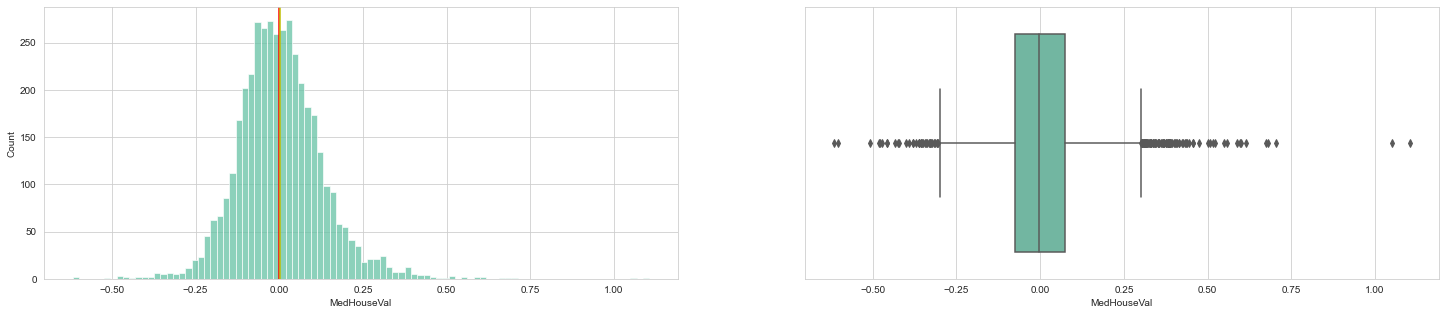

In [25]:
plot_residuals(test_y, y_hat_lr)

## RidgeCV

In [26]:
ridge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 2, 3], cv=5)
ridge.fit(train_X, train_y)
y_hat_ridge = ridge.predict(test_X)
print_results(ridge, test_y, y_hat_ridge)

Coefficients:  [ 1.04394255  0.08391025 -0.71148025  1.18885592  0.05134738 -1.22578275
 -0.86076743 -0.90474657  0.04486696]
   Intercept:  0.8919934876036804
       Alpha:  0.1
         MSE:  0.016703248463252426
          R2:  0.6451212590359459


C:\Users\User\AppData\Local\Temp\ipykernel_2152\2786487407.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


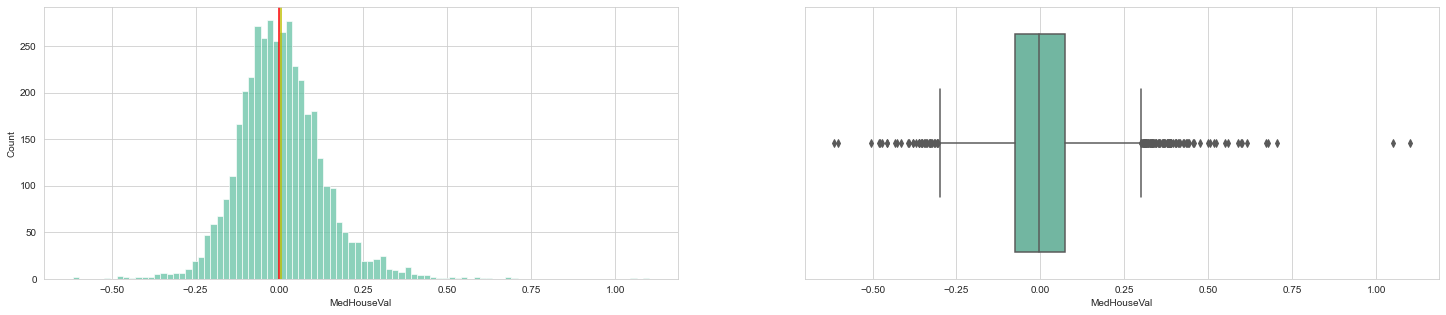

In [27]:
plot_residuals(test_y, y_hat_ridge)

## LassoCV

In [28]:
lasso = LassoCV(alphas=[1e-3, 1e-2, 1e-1, 1, 2, 3], cv=5)
lasso.fit(train_X, train_y)
y_hat_lasso = lasso.predict(test_X)
print_results(lasso, test_y, y_hat_lasso)

Coefficients:  [ 0.86318156  0.08496005 -0.          0.         -0.         -0.51476596
 -0.63436251 -0.64781255  0.01872132]
   Intercept:  0.6847896463738654
       Alpha:  0.001
         MSE:  0.01845969672133381
          R2:  0.6078035990749051


C:\Users\User\AppData\Local\Temp\ipykernel_2152\2786487407.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


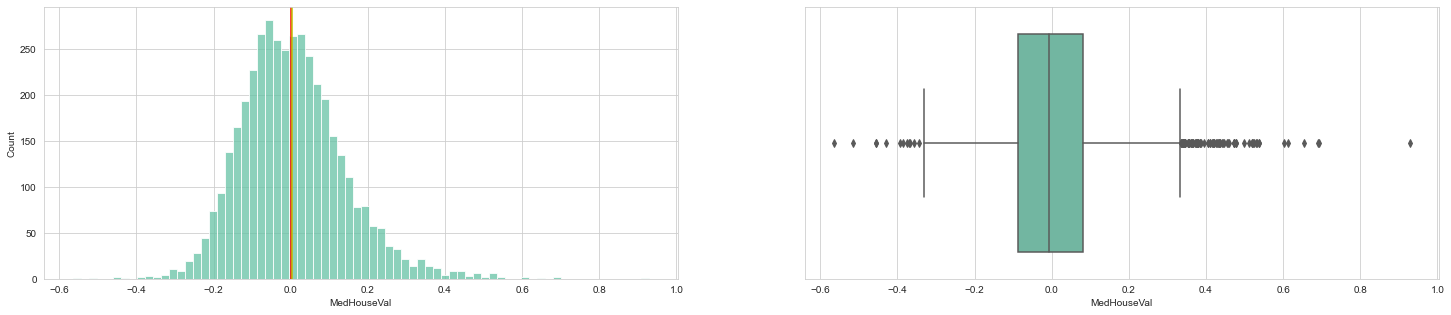

In [29]:
plot_residuals(test_y, y_hat_lasso)

## Polynomial Regression

In [30]:
pf = PolynomialFeatures(degree=2)

In [31]:
poly_features_train = pd.DataFrame(pf.fit_transform(train_X[['HouseAge', 'MedInc']]), index=train_X.index,
                                   columns=[f'c-{i}' for i in range(6)]).iloc[:, 1:]
poly_features_test = pd.DataFrame(pf.fit_transform(test_X[['HouseAge', 'MedInc']]), index=test_X.index,
                                  columns=[f'c-{i}' for i in range(6)]).iloc[:, 1:]

In [32]:
train_X = pd.concat([train_X, poly_features_train], axis=1)
test_X = pd.concat([test_X, poly_features_test], axis=1)

In [33]:
lr_poly = LinearRegression()
lr_poly.fit(train_X, train_y)
y_hat_lr_poly = lr_poly.predict(test_X)
print_results(lr_poly, test_y, y_hat_lr_poly)

Coefficients:  [ 1.94020059e+09 -1.24116364e+12 -7.45010376e-01  1.20746994e+00
  8.74633789e-02 -1.24264145e+00 -8.48541260e-01 -8.95854950e-01
  2.24609375e-02  1.24116364e+12 -1.94020059e+09  9.30786133e-02
  1.94885254e-01  6.05468750e-01]
   Intercept:  1.0861832460196497
         MSE:  0.016233856545379757
          R2:  0.6550940025534615


C:\Users\User\AppData\Local\Temp\ipykernel_2152\2786487407.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


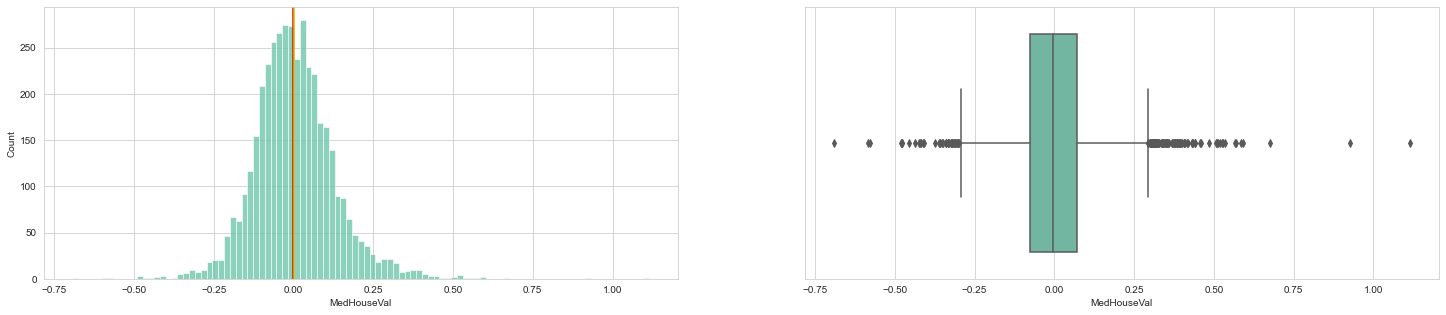

In [34]:
plot_residuals(test_y, y_hat_lr_poly)